## Original architecture UNet
In the this notebook is the pipeline to train and create submission with UNet built on the same architecture than the original paper. It take as input 527x572 images and produce an output of (388x388). For the training we pad the input images from 400 to 572 and an only predict the 388x388 center. For the submission we need to predict the whole image so we first extend the input to 792 then split it with overlap into 4 patches of (572x572) then merge the 4 output patches of (388x388) into one prediction of (608x608).

In [1]:
import torch
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam

from Original_UNet import *

import sys
 
sys.path.insert(0, '../')

from images_helpers import *
from unet_helpers import *
from metrics import *

### Load data, create training and test datatset

In [2]:
INPUT_UNET_SIZE = 572
OUTPUT_UNET_SIZE = 388

SUBMISSION_SIZE = 608

# UN_PREDICTED_MARGIN = (INPUT_UNET_SIZE - OUTPUT_UNET_SIZE) / 2 = 92
# SUBMISSION_SIZE + 2 * UN_PREDICTED_MARGIN = 792
SUBMISSION_PADDING_SIZE = 792

In [3]:
# Training dataset
train_imgs,_ = load_images(UNET_PREFIX + AUGMENTED_IMAGE_TRAIN_DIR)
train_gt_imgs,_ = load_images(UNET_PREFIX + AUGMENTED_GT_TRAIN_DIR)

train_imgs = pad_imgs(train_imgs, INPUT_UNET_SIZE)
train_gt_imgs = crop_imgs(train_gt_imgs, OUTPUT_UNET_SIZE)

# Switch the axis of the images
train_img_tensor = images_to_tensor(train_imgs)
train_gt_tensor = gts_to_tensor(train_gt_imgs)

train_dataset = torch.utils.data.TensorDataset(train_img_tensor, train_gt_tensor)


# Test dataset
test_imgs,_ = load_images(UNET_PREFIX + AUGMENTED_IMAGE_TEST_DIR)
test_gt_imgs,_ = load_images(UNET_PREFIX + AUGMENTED_GT_TEST_DIR)

test_imgs = pad_imgs(test_imgs, INPUT_UNET_SIZE)
test_gt_imgs = crop_imgs(test_gt_imgs, OUTPUT_UNET_SIZE)

# Switch the axis of the images
test_img_tensor = images_to_tensor(test_imgs)
test_gt_tensor = gts_to_tensor(test_gt_imgs)

test_dataset = torch.utils.data.TensorDataset(test_img_tensor, test_gt_tensor)

720 images loaded
720 images loaded
80 images loaded
80 images loaded


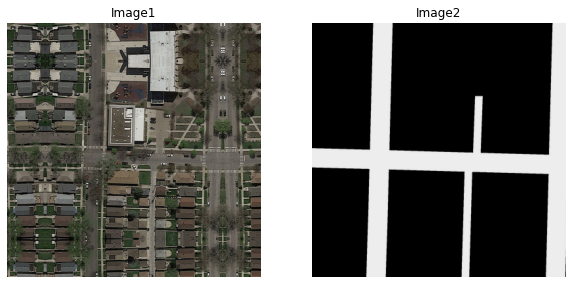

In [4]:
plot_images(train_imgs[0], train_gt_imgs[0])

### Train the UNet

In [5]:
INIT_LR = 0.001
NUM_EPOCHS = 60
BATCH_SIZE = 4
PROBA_DROPOUT = 0
PROBA_DROPOUT_MIDDLE = 0
lossFunc = BCEWithLogitsLoss()
#lossFunc = sigmoid_f1_loss

LOAD_MODEL = False
LOAD_MODEL_NAME = UNET_PREFIX + MODEL_DIR + "model_name"
LOAD_OPT_NAME = UNET_PREFIX + MODEL_DIR + "unet_f1_epoch_2_800_tr"

In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

unet = UNet(PROBA_DROPOUT, PROBA_DROPOUT_MIDDLE).to(DEVICE)

if LOAD_MODEL:
    unet.load_state_dict(torch.load(LOAD_MODEL_NAME))


opt = Adam(unet.parameters(), lr=INIT_LR)
if LOAD_MODEL:
    opt.load_state_dict(torch.load(LOAD_OPT_NAME))

In [7]:
unet, opt, losses, test_losses = train_model(unet, opt, NUM_EPOCHS, train_loader,test_dataset, lossFunc,\
                                             num_testing=80, num_test_per_epoch=7, num_save_per_epoch=7)

Epoch num: 1
Batch 1 loss 0.779457688331604, computed in 13.986431121826172s
Test set metrics on 80 images: acc->0.18293057179296413 f1->0.30206479646295864
Model ../model/unet_batch_0 saved
Batch 2 loss 0.7970395088195801, computed in 0.9480011463165283s


RuntimeError: CUDA out of memory. Tried to allocate 184.00 MiB (GPU 0; 8.00 GiB total capacity; 6.19 GiB already allocated; 0 bytes free; 6.57 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### Create submission

In [4]:
import numpy as np

In [12]:
model = UNet(PROBA_DROPOUT, PROBA_DROPOUT_MIDDLE).to(DEVICE)
model.load_state_dict(torch.load(UNET_PREFIX + MODEL_DIR + "unet_batch_0"))


sub_imgs, sub_dirs = load_submission_images(UNET_PREFIX)

# Pad image then split it in 4 patches of 572x572 to predict the whole image
pad_sub_imgs = pad_imgs(sub_imgs, SUBMISSION_PADDING_SIZE)
sub_imgs_patches = create_four_patches(pad_sub_imgs, INPUT_UNET_SIZE)
sub_tensor = images_to_tensor(sub_imgs_patches)

In [ ]:
sig = nn.Sigmoid()

patch_per_img = 4

with torch.no_grad():
    model.eval()
    idx = 0;
    
    files_pred = []
    for i in range(int(sub_tensor.shape[0]/patch_per_img)):
        patch_idx = i * patch_per_img
        x = sub_tensor[patch_idx:patch_idx+patch_per_img]

        y_pred = model(x)[:,0,:,:]
        y_pred = sig(y_pred)
        y_pred = y_pred.detach().numpy()
        y_pred = merge_four_patches(y_pred, OUTPUT_UNET_SIZE, SUBMISSION_SIZE)
        y_pred = np.where(y_pred > 0.5, 1, 0)            

        img_pred = from_mask_to_img(y_pred)
        
        pred_name = UNET_PREFIX + "predictions_submission/"+sub_dirs[idx]+".png"
        img_pred.save(pred_name)
        idx += 1
        files_pred.append(pred_name)
        print(f"Saved {i}")

    masks_to_submission("submissionUnet", *files_pred)

Saved 0
Saved 1
Saved 2
Saved 3
Saved 4
Saved 5
Saved 6
Saved 7
Saved 8
Saved 9
Saved 10
Saved 11
Saved 12
Saved 13
Saved 14
Saved 15
Saved 16
Saved 17
Saved 18
Saved 19
Saved 20
Saved 21
Saved 22
Saved 23
Saved 24
Saved 25
Saved 26
Saved 27
Saved 28
Saved 29
Saved 30
Saved 31
Saved 32
Saved 33
Saved 34
Saved 35
Saved 36
Saved 37
Saved 38


### Proof of concept of image dimension

Here we simulate the full pipeline on image to demonstartate that we have the same image before padding, splitting into patches than after reconstructing the ouput. We keep only one channel to better compare since the output of UNet has only one channel.

Basic image size (608, 608, 3)
Input patches size (572, 572, 3)
Output size (batch size = 4) torch.Size([4, 388, 388])
Reconstructed output shape (608, 608)


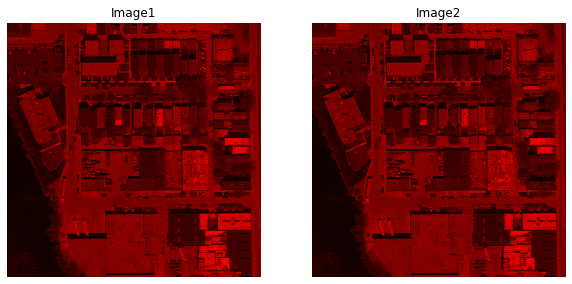

In [14]:
img = sub_imgs[0]
img[:,:,1]=0
img[:,:,2]=0
print(f"Basic image size {img.shape}")

# Input image pipeline
pad_img = pad_imgs([img], SUBMISSION_PADDING_SIZE)
patches = create_four_patches(pad_img, INPUT_UNET_SIZE)
print(f"Input patch size {patches[0].shape}")

# Simulate unet effect
preds = crop_imgs(patches, OUTPUT_UNET_SIZE)
tp = images_to_tensor(preds)[:,0]
print(f"Output size (batch size = 4) {tp.shape}")

# Output pipeline
tp = tp.detach().numpy()
rec_img = merge_four_patches(tp, OUTPUT_UNET_SIZE, SUBMISSION_SIZE)
print(f"Reconstructed output shape {rec_img.shape}")

rec = np.zeros_like(img)
rec[:,:,0] = rec_img

plot_images(img,rec)